# Notebook for running ERDiff alignment step by step

## 1. Source Domain: Training

Code for training is `VAE_Diffusion_CoTrain.py`

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import scipy.signal as signal
from tqdm import tqdm_notebook

import logging
import pickle
import random

from model_functions.Diffusion import *
from model_functions.VAE import *
from model_functions.ERDiff_utils import *

### 1.1 Set loggers to save the information

In [2]:
logger = logging.getLogger('train_logger')
logger.setLevel(level=logging.INFO)
handler = logging.FileHandler('train.log')
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
# logger.addHandler(console)
logger.info('python logging test')

### 1.2 Load source domain data

- trial spikes: neural firing rates
- trial vel: velocity
- trial dir: labels of direction, 8 classes

<img src="images/monkey_data.png" width="15%">

In [3]:
# Specify the trial length and number of neurons
len_trial,num_neurons = 37, 187

In [4]:
with open('datasets/Neural_Source.pkl', 'rb') as f:
    train_data1 = pickle.load(f)['data']
train_trial_spikes1, train_trial_vel1, train_trial_dir1 = train_data1['firing_rates'], train_data1['velocity'], train_data1['labels']

There are 209 trials, for each trial, the time length to use is 37 (minimal trial length - 1), number of neurons is 187, dimension of velocity is 2.

In [5]:
min(train_trial_spikes1[i].shape[0] for i in range(len(train_trial_spikes1)))

38

In [6]:
start_pos = 1 
end_pos = 1

train_trial_spikes_tide1 = np.array([spike[start_pos:len_trial+start_pos, :num_neurons] for spike in train_trial_spikes1])
print(np.shape(train_trial_spikes_tide1))

train_trial_vel_tide1 = np.array([spike[start_pos:len_trial+start_pos, :] for spike in train_trial_vel1])
print(np.shape(train_trial_vel_tide1))

(209, 37, 187)
(209, 37, 2)


In [7]:
array_train_trial_dir1 = np.expand_dims(np.array((train_trial_dir1), dtype=object),1)

train_trial_spikes_tide = train_trial_spikes_tide1
train_trial_vel_tide = train_trial_vel_tide1
train_trial_dic_tide = np.squeeze(np.vstack([array_train_trial_dir1]))
print(np.shape(train_trial_dic_tide))

(209,)


### 1.3 Data preprocessing

Apply gaussian smoother

In [8]:
bin_width = float(0.02) * 1000

kern_sd_ms = 100
kern_sd = int(round(kern_sd_ms / bin_width))
window = signal.gaussian(kern_sd, kern_sd, sym=True)
window /= np.sum(window)
filt = lambda x: np.convolve(x, window, 'same')

train_trial_spikes_smoothed = np.apply_along_axis(filt, 1, train_trial_spikes_tide)

/tmp/ipykernel_3431380/2824986634.py:5: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  window = signal.gaussian(kern_sd, kern_sd, sym=True)


In [9]:
train_trial_spikes_smoothed.shape

(209, 37, 187)

Visualize before and after smoothing

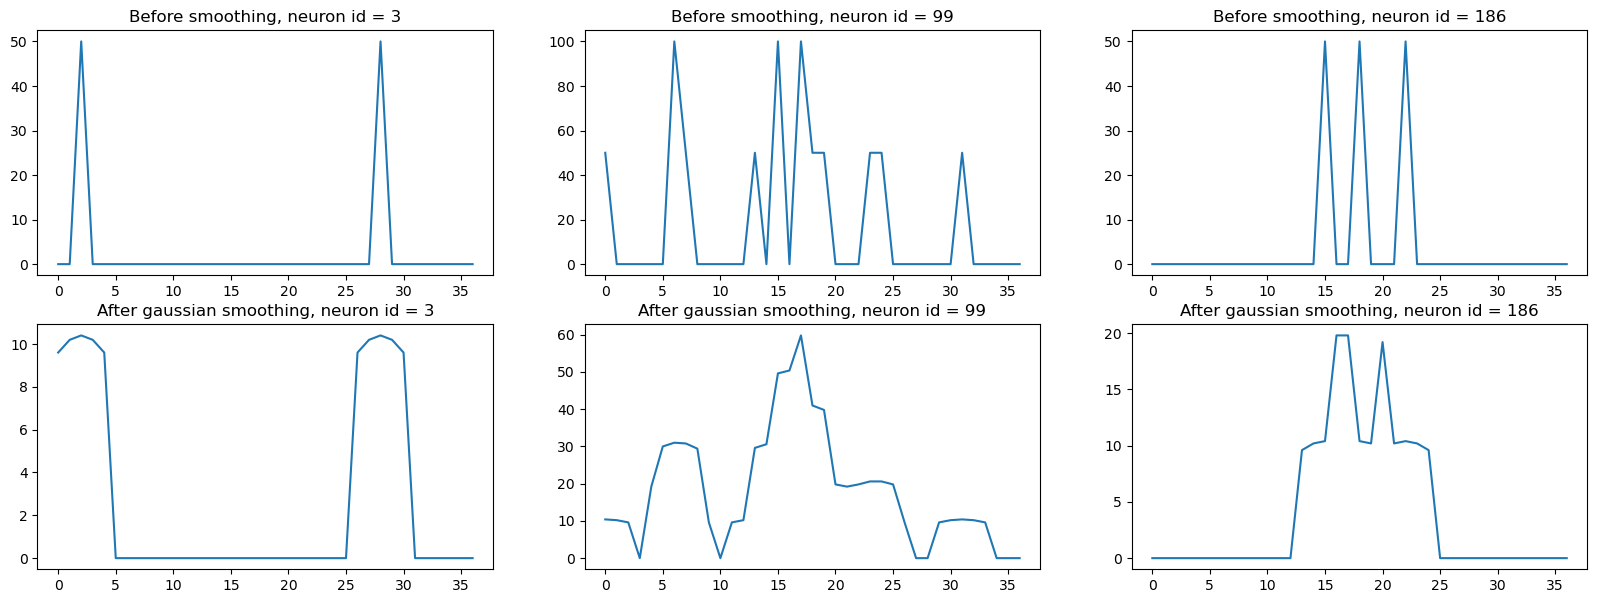

In [58]:
neuron_id_list = [3, 99, 186]
plt.figure(figsize=(20, 7))
for i in range(len(neuron_id_list)):
    neuron_id = neuron_id_list[i]
    ax1 = plt.subplot(2, len(neuron_id_list), i+1)
    ax1.plot(train_trial_spikes_tide[0, :, neuron_id])
    ax1.set_title("Before smoothing, neuron id = " + str(neuron_id))
    ax2 = plt.subplot(2, len(neuron_id_list), i+len(neuron_id_list)+1)
    ax2.plot(train_trial_spikes_smoothed[0, :, neuron_id])
    ax2.set_title("After gaussian smoothing, neuron id = " + str(neuron_id))
plt.show()

### 1.4 Randomly shuffle and split to train and validation set

In [10]:
indices = np.arange(train_trial_spikes_tide.shape[0])
np.random.seed(2023) 
np.random.shuffle(indices)
train_len = round(len(indices) * 0.80)
real_train_trial_spikes_smed, val_trial_spikes_smed = train_trial_spikes_smoothed[indices[:train_len]], train_trial_spikes_smoothed[indices[train_len:]]
real_train_trial_vel_tide, val_trial_vel_tide = train_trial_vel_tide[indices[:train_len]], train_trial_vel_tide[indices[train_len:]]
real_train_trial_dic_tide, val_trial_dic_tide = train_trial_dic_tide[indices[:train_len]], train_trial_dic_tide[indices[train_len:]]

### 1.5 Experiment settings

In [11]:
n_steps = 1
n_epochs = 500
batch_size = 16
ae_res_weight = 10
kld_weight = 1
n_batches = len(real_train_trial_spikes_smed)//batch_size
print("number of batches:", n_batches)

mse_criterion = nn.MSELoss()
poisson_criterion = nn.PoissonNLLLoss(log_input=False)

l_rate = 0.001

number of batches: 10


In [12]:
# Training
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(21)

### 1.6 Build the model

<img src="images/training.png" width="50%">


In [13]:
model = VAE_Model()
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

In [14]:
def get_loss(model, spike, emg):
    re_sp_, vel_hat_,mu, log_var = model(spike, train_flag= True)
    ae_loss = poisson_criterion(re_sp_, spike)
    emg_loss = mse_criterion(vel_hat_, emg)
    kld_loss = torch.mean(0.5 * (- log_var + mu ** 2 + log_var.exp() - 1))
    total_loss = ae_res_weight * ae_loss + emg_loss + kld_weight * kld_loss
    # total_loss = ae_res_weight * ae_loss 
    return total_loss

In [15]:
timesteps = 50

# define beta schedule
betas = quadratic_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

In [16]:
# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

### 1.7 Start to train

In [17]:
train_spikes = np.load("npy_files/train_latents.npy")
train_spike_data = np.expand_dims(train_spikes,1).astype(np.float32)
train_spike_data = train_spike_data.transpose(0,1,3,2)

In [18]:
train_spike_data.shape

(167, 1, 8, 37)

In [19]:
real_train_trial_spikes_stand = (real_train_trial_spikes_smed)
val_trial_spikes_stand = (val_trial_spikes_smed)

spike_train = Variable(torch.from_numpy(real_train_trial_spikes_stand)).float()
spike_val = Variable(torch.from_numpy(val_trial_spikes_stand)).float()

emg_train = Variable(torch.from_numpy(real_train_trial_vel_tide)).float()
emg_val = Variable(torch.from_numpy(val_trial_vel_tide)).float()

In [20]:
global_batch_size = 16
dataloader = DataLoader(train_spike_data, batch_size=global_batch_size)
batch = next(iter(dataloader))

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = 1

dm_model = diff_STBlock(input_dim)
dm_model.to(device)

dm_optimizer = Adam(dm_model.parameters(), lr=1e-3)

In [22]:
pre_loss = 1e10 # Save the loss

pre_total_loss_ = 1e18
last_improvement = 0
loss_list = []

In [23]:
for epoch in tqdm_notebook(range(n_epochs)):
    spike_gen_obj = get_batches(real_train_trial_spikes_stand,batch_size)
    emg_gen_obj = get_batches(real_train_trial_vel_tide,batch_size)
    for ii in range(n_batches):
        optimizer.zero_grad()
        spike_batch = next(spike_gen_obj)
        emg_batch = next(emg_gen_obj)

        spike_batch = Variable(torch.from_numpy(spike_batch)).float()
        emg_batch = Variable(torch.from_numpy(emg_batch)).float()

        # Loss
        batch_loss = get_loss(model, spike_batch, emg_batch)

        batch_loss.backward()
        optimizer.step()
        

    with torch.no_grad():
        val_total_loss = get_loss(model, spike_val, emg_val)
        loss_list.append(val_total_loss.item())

        _, _, train_latents, _ = model(spike_train, train_flag = False)

        if val_total_loss < pre_total_loss_: 
            pre_total_loss_ = val_total_loss
            torch.save(model.state_dict(),'model_checkpoints/source_vae_model_new')


            np.save("./npy_files/train_latents_new.npy",train_latents)

        
    train_latents = np.expand_dims(train_latents,1).astype(np.float32)
    train_spike_data = train_latents.transpose(0,1,3,2)


    dataloader = DataLoader(train_spike_data, batch_size=global_batch_size)

    batch = next(iter(dataloader))
    

    total_loss = 0
    for step, batch in enumerate(dataloader):
        dm_optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)


        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(dm_model, batch, t)

        print("Step", step, " Loss:", loss.item())
        total_loss += loss.item()

        loss.backward()
        dm_optimizer.step()

    print("total Loss of epoch ", epoch, " is ", total_loss)

    if total_loss < pre_loss:
        pre_loss = total_loss
        torch.save(dm_model.state_dict(), 'model_checkpoints/source_diffusion_model_new')

/tmp/ipykernel_3431380/3446123673.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/500 [00:00<?, ?it/s]

Step 0  Loss: 0.8132175207138062
Step 1  Loss: 0.8100867867469788
Step 2  Loss: 0.815028727054596
Step 3  Loss: 0.7940422296524048
Step 4  Loss: 0.8037274479866028
Step 5  Loss: 0.7856090664863586
Step 6  Loss: 0.7988925576210022
Step 7  Loss: 0.759097158908844
Step 8  Loss: 0.78489089012146
Step 9  Loss: 0.7787379622459412
Step 10  Loss: 0.7785270810127258
total Loss of epoch  0  is  8.72185742855072
Step 0  Loss: 0.7721797227859497
Step 1  Loss: 0.7777519822120667
Step 2  Loss: 0.7556346654891968
Step 3  Loss: 0.7643831372261047
Step 4  Loss: 0.7534956932067871
Step 5  Loss: 0.7568359375
Step 6  Loss: 0.6874943971633911
Step 7  Loss: 0.7476314902305603
Step 8  Loss: 0.750187337398529
Step 9  Loss: 0.6666913628578186
Step 10  Loss: 0.6706206798553467
total Loss of epoch  1  is  8.10290640592575
Step 0  Loss: 0.722862184047699
Step 1  Loss: 0.6638414859771729
Step 2  Loss: 0.6517336964607239
Step 3  Loss: 0.6163535118103027
Step 4  Loss: 0.640303373336792
Step 5  Loss: 0.62666422128677